[Reference](https://medium.datadriveninvestor.com/sentiment-analysis-on-stock-price-movement-2f8a83a4884b)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<Figure size 720x576 with 0 Axes>

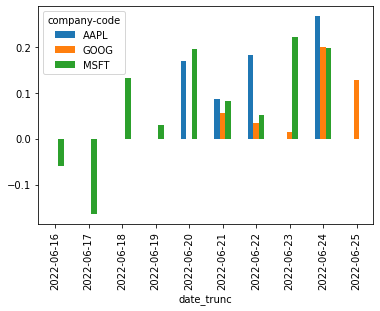

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('vader_lexicon')

class datetime_parser:

	def __init__(self):
		self.date = ''
		self.time = ''
	
	def parsing(self,dateinfo):
		dateinfo = [x.replace('\xa0\xa0', '') for x in dateinfo.split(' ')]
		if len(dateinfo) > 1:
			self.date = dateinfo[0]
			self.time = dateinfo[1]
		else:
			self.time = dateinfo[0]
		
		return datetime.strptime(self.date + " " + self.time, "%b-%d-%y %I:%M%p")

def stock_ticker_crawler(limit=10):
	html = requests.get('https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/').text
	soup = BeautifulSoup(html, 'html.parser')
	companyName = [x.get_text(strip=True) for x in soup.find_all('div', {'class': 'company-name'})][:limit]
	companyCode = [x.get_text(strip=True) for x in soup.find_all('div', {'class': 'company-code'})][:limit]
	
	return [{'company-code': x, 'company-name': y} for x, y in zip(companyCode, companyName)]	

def news_headlines(ticker):
	url = f'https://finviz.com/quote.ashx?t={ticker}'
	req = requests.get(url, headers={'user-agent': 'nlp_bot'}).text
	html = BeautifulSoup(req, 'html.parser')
	headline = html.find(id='news-table')

	return headline

def preprocessing(headline):
	dParser = datetime_parser()
	table = [x.a.text for x in headline.findAll('tr')]
	date_info = [dParser.parsing(x.td.text) for x in headline.findAll('tr')]
	
	headlines = [{"news-title": x, "date": y} for x, y in zip(table, date_info)]
	
	return headlines

def convert_to_DF(stock, news):
	stock_info = []
	for x in news:
		stock_info.append({**stock,**x})
	
	return pd.DataFrame(stock_info)

def sentiment_analysis(title):
	return sia().polarity_scores(title)['compound']

def data_visualization(df):
	
	plt.figure(figsize=(10,8))
	df['date_trunc'] = pd.to_datetime(df['date']).dt.date 
	avg_df= df[['company-code', 'date_trunc', 'scores']].groupby(['company-code', 'date_trunc']).mean().unstack()

	avg_df = avg_df.xs('scores', axis="columns").transpose()
	#avg_df.to_excel('process.xlsx')
	avg_df.plot(kind='bar')
	plt.show()

def main():
	stock_info = stock_ticker_crawler(limit=3)
	news_headline_info = [preprocessing(news_headlines(x['company-code'])) for x in stock_info]
	stock_data = [convert_to_DF(x, y) for x, y in zip(stock_info, news_headline_info)]
	stock_data = pd.concat(stock_data)
	
	## VADER Sentiment Analysis calculating for polarity scores based on title 
	stock_data['scores'] = stock_data['news-title'].apply(sentiment_analysis)

	#stock_data.to_excel('final_data.xlsx')
	#print(stock_data)
	data_visualization(stock_data)
		
if __name__ == '__main__':
	main()

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
test1 = "I Love you.."
print(sia().polarity_scores(test1))

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}


In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
test1 = "I Love you.."
print(test1, "==>",sia().polarity_scores(test1))
test2 = "Sorry, I don't love you.."
print(test2, "==>",sia().polarity_scores(test2))
test3 = "Let us be friend.."
print(test3, "==>",sia().polarity_scores(test3))

I Love you.. ==> {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
Sorry, I don't love you.. ==> {'neg': 0.7, 'neu': 0.3, 'pos': 0.0, 'compound': -0.5673}
Let us be friend.. ==> {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
